#Lectura de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

#Evitamos los valores nulos con la instruccion dropna()
penguins = pd.read_csv('/content/drive/MyDrive/Azure DS Certification/Create Machine Learning Models On Azure/Semana3/Data/penguins.csv').dropna()

penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,0


Se puede ver que la escala de FlipperLenght y BodyMass se encuentra en una escala bastante distinta a las de los primeros 2 atributos, por lo que se pueden mandar a una escala similar

In [ ]:
#El atributo basta con escalarlo por 1/10 al estar en centenas
penguins['FlipperLength'] = penguins['FlipperLength']/10
#El atributo requiere escalarlo por 1/100 ya que esta en millares
penguins['BodyMass'] = penguins['BodyMass']/100
print(penguins.shape)

(342, 5)


**Vamos a sobremuestrear nuestro conjunto ya que es bastante pequeno para Deep Learning**

In [ ]:
penguins=pd.concat([penguins, penguins, penguins, penguins]).reset_index().drop(columns='index')

In [ ]:
from sklearn.model_selection import train_test_split

features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
label = 'Species'

# Dividimos las observaciones en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(penguins[features].values,
                                                    penguins[label].values,
                                                    test_size=0.30,
                                                    random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))

Training Set: 239, Test Set: 103 



**Recomendacion de librerias por parte de AzureMl**

In [ ]:
!pip install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cpu (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2)
ERROR: No matching distribution found for torch==1.9.0+cpu


In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Fijamos una seed para reproducir el experimento
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.0.1+cu118


#Preparando los conjuntos de datos

Dado que Pytorch no trabaja directamente con arreglos de Numpy, es necesario convertirlos a Tensores que son bastante similares, pero Pytorch puede trabajar con ellos

In [ ]:
# Creamos un tensor con flotantes para los atributos
train_x = torch.Tensor(x_train).float()
# Creamos un tensor con enteros (long) para las clases
train_y = torch.Tensor(y_train).long()
#Creamos un dataset con el formato de Pytorch, este objeto es iterable
train_ds = td.TensorDataset(train_x,train_y)
#Vaciamos el dataset en un Dataloader, el cual toma 'rebanadas' de nuestro conjunto de datos
train_loader = td.DataLoader(train_ds, batch_size=20,shuffle=False, num_workers=1)

# Creamos un tensor con flotantes para los atributos
test_x = torch.Tensor(x_test).float()
# Creamos un tensor con enteros (long) para las clases
test_y = torch.Tensor(y_test).long()
#Creamos un dataset con el formato de Pytorch, este objeto es iterable
test_ds = td.TensorDataset(test_x,test_y)
#Vaciamos el dataset en un Dataloader, el cual toma 'rebanadas' de nuestro conjunto de datos
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


#Arquitectura

Se propone un clasificador lineal con una capa oculta:

$num\_features ---> hl---> 2*hl---> Num\_classes$

In [ ]:
#Dimension de la capa oculta
hl = 10

# Define the neural network
class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, 2* hl)
        self.fc3=nn.Linear(2*hl,  len(set(penguins['Species'])))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Create a model instance from the network
model = PenguinNet()
print(model)

PenguinNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=3, bias=True)
)


#Funciones de entrenamiento

In [ ]:
def train(model, data_loader, optimizer):
    # Poner el modelo en modo entrenamiento
    model.train()
    train_loss = 0

    #Recorremos #batch y cada tensor en el dataloader
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #Reiniciamos el acumulador de gradiente en cada iteracion
        optimizer.zero_grad()
        #Evaluamos el tensor en el modelo
        out = model(data)
        #Calculamos su valor de perdida con respecto al objetivo
        loss = loss_criteria(out, target)
        #Agregamos su perdida a una cuenta general del entrenamiento
        train_loss += loss.item()

        # Calculamos la derivada
        loss.backward()
        #Actualizamos los parametros entrenaados
        optimizer.step()

    #Buscamos el total de la perdida durante el entrenamiento
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    #regresamos la perdida promedio
    return avg_loss


def test(model, data_loader):
    # Ponemos el modelo en modo evaluacion, para evitar modificar los gradientes
    model.eval()
    test_loss = 0
    correct = 0
    #Sin modificar los gradientes
    with torch.no_grad():
        batch_count = 0
        #Para cada numero de batch y cada tensor en el dataloader
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Obtenemos la prediccion del modelo entrenado
            out = model(data)

            # Calculamos la perdida del valor real
            test_loss += loss_criteria(out, target).item()

            #Tomamos la clase de mayor probabilidad como la asignada
            _, predicted = torch.max(out.data, 1)
            #Tomamos el numero de aciertos en cada batch
            correct += torch.sum(target==predicted).item()

    # Calculamos la perdida promedio
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

    # Regresamos la perdida promedio
    return avg_loss


#Entrenamiento

In [ ]:
# La funcion de perdida para clasificacion, soporta clasificacion multiclase
loss_criteria = nn.CrossEntropyLoss()

#Usamos el Optimizador Adam
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Registro de metricas durante el entrenamiento
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))

    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)

    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)

    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1
Training set: Average loss: 2.081632
Validation set: Average loss: 1.079570, Accuracy: 155/411 (38%)

Epoch: 2
Training set: Average loss: 0.841975
Validation set: Average loss: 0.686381, Accuracy: 318/411 (77%)

Epoch: 3
Training set: Average loss: 0.589350
Validation set: Average loss: 0.541085, Accuracy: 321/411 (78%)

Epoch: 4
Training set: Average loss: 0.470317
Validation set: Average loss: 0.450862, Accuracy: 326/411 (79%)

Epoch: 5
Training set: Average loss: 0.383615
Validation set: Average loss: 0.376551, Accuracy: 348/411 (85%)

Epoch: 6
Training set: Average loss: 0.315103
Validation set: Average loss: 0.313273, Accuracy: 365/411 (89%)

Epoch: 7
Training set: Average loss: 0.260811
Validation set: Average loss: 0.261789, Accuracy: 390/411 (95%)

Epoch: 8
Training set: Average loss: 0.218479
Validation set: Average loss: 0.221930, Accuracy: 393/411 (96%)

Epoch: 9
Training set: Average loss: 0.185722
Validation set: Average loss: 0.192027, Accuracy: 393/411 (96%)

E

# Grafica de perdida, entrenamiento vs validacion

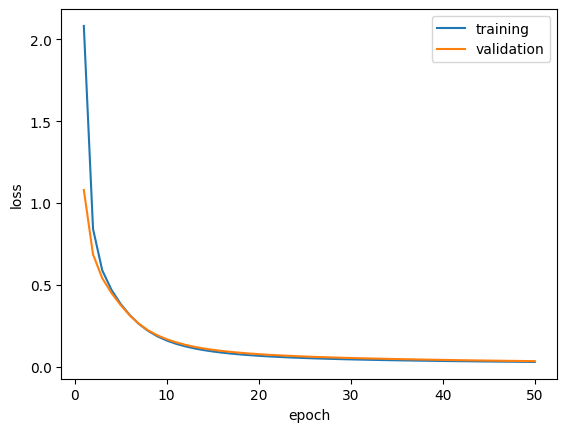

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#Evaluacion

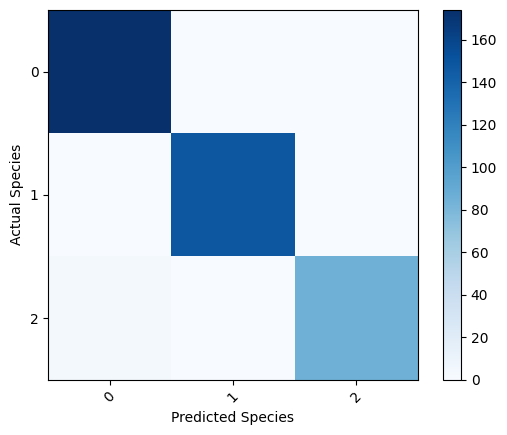

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Ponemos el modelo en modo evaluacion (para no modificar)
model.eval()

# Generamos las predicciones del conjunto de entrenamiento
x = torch.Tensor(x_test).float()
#Solo nos interesa aquella clase asociada a la mayor porbabilidad, por eso tomamos el maximo
_, predicted = torch.max(model(x).data, 1)

# #Matriz de confusion
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(set(penguins['Species'])))
plt.xticks(tick_marks, set(penguins['Species']), rotation=45)
plt.yticks(tick_marks, set(penguins['Species']))
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

# Guardamos el modelo entrenado

In [ ]:
#le ponemos un nombre
model_file = 'penguin_classifier.pt'
#Guardamos los valores de los parametros entrenados y su direccion
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as penguin_classifier.pt


#Cargar modelo entrenado

In [ ]:
#Una nueva observacion
x_new = [[50.4,15.3,20,50]]
print ('New sample: {}'.format(x_new))

#Creamos un modelo vacio, pero cargamos los pesos entrenados anteriormente
model = PenguinNet()
model.load_state_dict(torch.load(model_file))

# #Ponemos el modelo en modo evaluacion
model.eval()

# Generamos la prediccion, bastante similar a en la evaluacion
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)

New sample: [[50.4, 15.3, 20, 50]]
